<span style='font-size: 2.5em'><b>São Paulo Housing 🏡</b></span><br/>
<span style='font-size: 1.5em'>Predict the median housing price in São Paulo apartments</span>

<span style="background-color: #ffc351; padding: 4px; font-size: 1em;"><b>Sprint #2</b></span>



### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Prof**: Samuel Martins (Samuka) <br/>

#### Projeto de Estudo

**Aluno**: Carlos Danilo Tomé

**Dataset**: https://www.kaggle.com/argonalyst/sao-paulo-real-estate-sale-rent-april-2019

This data is about 13,000 apartments in São Paulo City - Brazil available in Kaggle platform.

**Final Goal**: Predict housing price in São Paulo.

---

## 🎯 Sprint Goals
- Choosing final sample
- Adding features
- Create a Function to imput na values
- Create a Custom Tranformer
- Build a Pipeline 
- Create a column transform
- Try other models/algorithms (mainly nonlinear)
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

path='./datasets/sao-paulo-properties-april-2019.csv'
housing = pd.read_csv(path)

housing.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


In [2]:
housing[housing['Negotiation Type']=='sale'].shape

(6412, 16)

## 🧹 Choosing final sample

We are hold only data that type of negotiation is Sale.

In [3]:
# Set only sale Negotiation Type - Sale
housing = housing[housing['Negotiation Type']=='sale']

# Drop duplicated data
housing.drop_duplicates(keep='first', inplace=True)

# Drop columns
housing.drop(['Negotiation Type', 'Property Type'], axis=1, inplace=True)

# Split data between train and test
housing_train, housing_test = train_test_split(housing, test_size=0.2, stratify=housing['District'], random_state=42)

In [4]:
# Save data after split
housing_train.to_csv('./datasets/housing_train.csv', sep=';',index=False)
housing_test.to_csv('./datasets/housing_test.csv', sep=';',index=False)

## 🔲 1. Pré Processing and Adding features

In [5]:
housing_train = pd.read_csv('./datasets/housing_train.csv', sep=';')

housing_train.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,750000,1465,152,3,2,1,2,0,0,1,0,Vila Jacuí/São Paulo,-23.499458,-46.449633
1,570000,604,84,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,-23.541739,-46.753211
2,450000,680,73,3,2,1,1,1,0,0,0,Socorro/São Paulo,-23.689616,-46.698819


In [6]:
X_train = housing_train.drop(['Price'], axis=1).copy()
y_train = housing_train['Price'].copy()

X_train.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,1465,152,3,2,1,2,0,0,1,0,Vila Jacuí/São Paulo,-23.499458,-46.449633
1,604,84,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,-23.541739,-46.753211
2,680,73,3,2,1,1,1,0,0,0,Socorro/São Paulo,-23.689616,-46.698819
3,700,46,2,2,1,1,0,0,0,0,Carrão/São Paulo,-23.548712,-46.529097
4,0,41,2,2,1,1,1,0,0,1,Cursino/São Paulo,-23.652923,-46.614163


### Adding Features

In [7]:
X_train['Total Rooms']            = X_train['Rooms'] + X_train['Toilets'] + X_train['Suites']
X_train['Total Bedrooms']         = X_train['Rooms'] + X_train['Suites']
X_train.head(3)

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude,Total Rooms,Total Bedrooms
0,1465,152,3,2,1,2,0,0,1,0,Vila Jacuí/São Paulo,-23.499458,-46.449633,6,4
1,604,84,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,-23.541739,-46.753211,6,4
2,680,73,3,2,1,1,1,0,0,0,Socorro/São Paulo,-23.689616,-46.698819,6,4


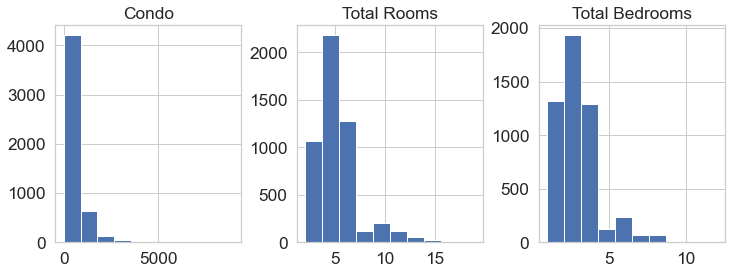

In [8]:
X_train.hist(column=['Condo','Total Rooms', 'Total Bedrooms'], figsize=(12,4),layout=(1,3));

### Adding District Rate

In [9]:
district = housing_train.groupby(['District']).apply(lambda x: pd.Series(dict(qtd_housing          = ((x.Price.count()))
                                                                   ,mean_housing_price   =  ((x.Price.mean())) 
                                                                   ,mean_housing_size    =  ((x.Size.mean()))
                                                                   ,mean_Price_per_square_meter =  ((x.Price.sum()))/((x.Size.sum()))
                                                                   ,mean_housing_condo   =  ((x.Condo.mean()))
                                                                   ,pct_new_housing      = ((x.New.sum())*100/(x.Price.count()))
                                                                   ,Latitude_district    =  ((x.Latitude.mean())) 
                                                                   ,Longitude_district   =  ((x.Longitude.mean()))
))).reset_index() 
district.head()

,District,qtd_housing,mean_housing_price,mean_housing_size,mean_Price_per_square_meter,mean_housing_condo,pct_new_housing,Latitude_district,Longitude_district
0,Alto de Pinheiros/São Paulo,78.0,2.571864e+06,181.115385,14200.140582,1417.487179,0.000000,-23.030073,-45.573297
1,Anhanguera/São Paulo,29.0,1.016517e+06,154.241379,6590.431478,1071.862069,0.000000,-23.665478,-46.691436
2,Aricanduva/São Paulo,64.0,2.986544e+05,56.625000,5274.249448,324.359375,9.375000,-21.821550,-42.964857
3,Artur Alvim/São Paulo,66.0,1.893636e+05,48.333333,3917.867712,122.848485,7.575758,-13.964309,-27.506922
4,Barra Funda/São Paulo,94.0,5.845222e+05,72.457447,8067.110556,511.468085,4.255319,-22.336662,-42.747301


In [10]:
district['district_rate'] = pd.qcut(district['mean_Price_per_square_meter'],
                                                 q=4,
                                                 labels=[1, 2, 3, 4])

In [11]:
district.to_csv('./datasets/district_information.csv', sep=';',index=False)

In [61]:
# X_train = pd.merge(X_train, district[['District','district_rate']], how='left', on=['District'])

In [62]:
# X_train.drop(['District'], axis=1, inplace=True)

## 🚩 2. Create a Function to imput na values


In [63]:
min_y= -23.8
max_y= -23.2
min_x= -46.95
max_x= -46

X_train[ (X_train['Latitude'] < min_y )   |
         (X_train['Longitude'] < min_x )  |
         (X_train['Latitude']  > max_y )  |
         (X_train['Longitude'] > max_x )  ].shape

(377, 15)

In [64]:
X_train['Latitude'][(X_train['Latitude'] < min_y )  |
                   (X_train['Longitude'] < min_x )  |
                   (X_train['Latitude']  > max_y )  |
                   (X_train['Longitude'] > max_x )  
                   ]= np.nan

X_train['Longitude'][(X_train['Latitude'] < min_y ) |
                   (X_train['Longitude'] < min_x )  |
                   (X_train['Latitude']  > max_y )  |
                   (X_train['Longitude'] > max_x )  
                   ]= np.nan

<ipython-input-64-2bb8c1f3fde5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Latitude'][(X_train['Latitude'] < min_y )  |
<ipython-input-64-2bb8c1f3fde5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Longitude'][(X_train['Latitude'] < min_y ) |


In [65]:
# Create a tablea that represents a median point per neighborhood
geo_district = housing_train.groupby(['District']).apply(lambda x: pd.Series(dict(Latitude   =  ((x.Latitude.mean())) 
                                                                           ,Longitude    =  ((x.Longitude.mean()))   
                                                                           ))).reset_index()
geo_district.head(4)

,District,Latitude,Longitude
0,Alto de Pinheiros/São Paulo,-23.030073,-45.573297
1,Anhanguera/São Paulo,-23.665478,-46.691436
2,Aricanduva/São Paulo,-21.821550,-42.964857
3,Artur Alvim/São Paulo,-13.964309,-27.506922


In [66]:
X_train = pd.merge(X_train, geo_district, how='left', on=['District'],suffixes=["", "_district"])

In [67]:
X_train.Latitude = np.where(X_train.Latitude.isnull()
                                  , X_train.Latitude_district # If Latitude is null replace with Latitude_district
                                  , X_train.Latitude # else, keep the original value
                                 )
X_train.Longitude = np.where(X_train.Longitude.isnull()
                                  , X_train.Longitude_district # If Latitude is null replace with Longitude_district
                                  , X_train.Longitude # else, keep the original value
                                 )

In [68]:
X_train.drop(['Latitude_district', 'Longitude_district', 'District'], axis=1, inplace=True)

## 🚩 3. Create a Custom Tranformer


In [70]:

class pre_processing_transform(BaseEstimator, TransformerMixin):
    
    # Classe que realiza Pré Processamento para os problemas 1 e 2
    # Objetivo: Transformador customizado e adaptado ao sklearn
    # Observacoes: Com esta configuração essa classe ganha os atributos "fit","fit_transform" e "transform", nativas do sklearn
    # Parametros: "adc_faturamento_per_capita" -> se True adiciona a coluna "faturamento_per_capita". Default : False
    
    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        return self
    
    def transform(self, X, y = None):
        temp = X.copy()
        
        # Create Columns
        temp['Total Rooms']            = temp['Rooms'] + temp['Toilets'] + temp['Suites']
        temp['Total Bedrooms']         = temp['Rooms'] + temp['Suites']
        
        
        # Add District Rate
        district = pd.read_csv('./datasets/district_information.csv', sep=';')
        
        temp = pd.merge(temp, district[['District','district_rate','Latitude_district','Longitude_district']],
                           how='left', on=['District'])

        # Drop object Column District   
        temp.drop(['District'], axis=1, inplace=True)
        
        # Remove outliers and replace as NAN
        temp['Latitude'][(temp['Latitude'] < min_y )  |
                   (temp['Longitude'] < min_x )  |
                   (temp['Latitude']  > max_y )  |
                   (temp['Longitude'] > max_x )  
                   ]= np.nan

        temp['Longitude'][(temp['Latitude'] < min_y ) |
                           (temp['Longitude'] < min_x )  |
                           (temp['Latitude']  > max_y )  |
                           (temp['Longitude'] > max_x )  
                           ]= np.nan
        
        # Imput NA values with mean point neigborhood
        temp.Latitude = np.where(temp.Latitude.isnull()
                                  , temp.Latitude_district # If Latitude is null replace with Latitude_district
                                  , temp.Latitude # else, keep the original value
                                 )
        temp.Longitude = np.where(temp.Longitude.isnull()
                                          , temp.Longitude_district # If Latitude is null replace with Longitude_district
                                          , temp.Longitude # else, keep the original value
                                         )

        # Drop temp Columns
        temp.drop(['Latitude_district', 'Longitude_district'], axis=1, inplace=True)
        
      
        return temp


## 🚩 4. Build a Pipeline 

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [72]:
pipeline = Pipeline([
        
    #Adicionando as colunas
    ('Criando as colunas', pre_processing_transform()),
    
    # Escalonando os valores pelo desvio padrão
    ('escalonando', StandardScaler())
])

In [73]:
housing_train = pd.read_csv('./datasets/housing_train.csv', sep=';')

X_train = housing_train.drop(['Price'], axis=1).copy()
y_train = housing_train['Price'].copy()

X_train.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,1465,152,3,2,1,2,0,0,1,0,Vila Jacuí/São Paulo,-23.499458,-46.449633
1,604,84,3,2,1,2,0,0,1,0,Jaguaré/São Paulo,-23.541739,-46.753211
2,680,73,3,2,1,1,1,0,0,0,Socorro/São Paulo,-23.689616,-46.698819
3,700,46,2,2,1,1,0,0,0,0,Carrão/São Paulo,-23.548712,-46.529097
4,0,41,2,2,1,1,1,0,0,1,Cursino/São Paulo,-23.652923,-46.614163


In [74]:
# Basta agora aplicar o fit_transform no conjunto de treino
X_train = pipeline.fit_transform(X_train)

<ipython-input-70-177fd85e0404>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Latitude'][(temp['Latitude'] < min_y )  |
<ipython-input-70-177fd85e0404>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Longitude'][(temp['Latitude'] < min_y ) |


In [75]:
X_train

array([[ 1.48361557,  1.41669665,  0.94307354, ...,  0.32454573,
         0.01368112, -1.48092475],
       [ 0.1016763 ,  0.09321455,  0.94307354, ...,  0.32454573,
         0.01368112,  0.33767249],
       [ 0.22365932, -0.12087815,  0.94307354, ...,  0.32454573,
         0.01368112, -0.57162613],
       ...,
       [-0.56281019, -0.82154514, -0.46219803, ..., -0.14316011,
         0.01368112,  0.33767249],
       [-0.86776775, -0.54906353, -0.46219803, ..., -0.14316011,
         0.01368112, -0.57162613],
       [-0.4665078 , -0.47121164, -0.46219803, ..., -1.07857178,
        -1.18573662, -0.57162613]])

### Saving Pipeline

In [78]:
joblib.dump(pipeline, './preprocessed_pipeline.pkl')

['./preprocessed_pipeline.pkl']

## 🏁 5. Create a full Pipeline with the model



In [128]:
# Load train data
housing_train = pd.read_csv('./datasets/housing_train.csv', sep=';')

X_train = housing_train.drop(['Price'], axis=1).copy()
y_train = housing_train['Price'].copy()

In [129]:
# Load a pre processed pipeline
loaded_preprocessed_pipeline = joblib.load('./preprocessed_pipeline.pkl')

### Testing model application

In [131]:
# Função que avalia os modelos de Regressão
# Queremos focar nas métricas 
# R²: pela sua interpretabilidade ( por estar entre 0 e 1) 
# RSME: ( pois mensura em valores o erro médio)

def resultados_regressao(modelo, nome_do_modelo ):
      
    resultado = modelo.predict(X_teste)
        
    R_2  =  r2_score(y_teste,resultado)
    mse  =  mean_squared_error(y_teste, resultado, squared = False) 
    rmse =  mse **0.5
    MAE  =  mean_absolute_error(y_teste,resultado)

    
    print('R²                      : ', R_2  )
    print('Erro Médio ao quadrado  : ', mse  )
    print('Erro Médio              : ', rmse )
    print('Erro Absoluto Médio     : ', MAE  )

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [134]:
# RandomForest Tree Regressor

print("Modelo Test - Random Forest Regressor\n") 

# Cria dicionario com os parametros do modelo
parametros = [{'random_forest_test__min_samples_leaf':[3,8],
              'random_forest_test__min_samples_split':[50,80],
              'random_forest_test__n_estimators':[250,500,750],
              'random_forest_test__random_state': [42]
}]

# Cria o objeto com o modelo do SKLearn
modelo_2 = RandomForestRegressor()

# Create a full pipeline

full_pipeline = Pipeline([
        ('preprocessing', loaded_preprocessed_pipeline),
        ('random_forest_test', modelo_2)
])

# GridSearch
grid = GridSearchCV(full_pipeline,parametros,cv=5, scoring = 'neg_mean_squared_error', return_train_score=True, verbose=1)

# Treina o modelo
grid.fit(X_train, y_train)

# Melhor Combinação de Parametros
melhor_Decision_Tree = grid.best_estimator_

print('Melhores parametros encontrados: \n',grid.best_params_)

Modelo Test - Random Forest Regressor

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parametros encontrados: 
 {'random_forest_test__min_samples_leaf': 8, 'random_forest_test__min_samples_split': 50, 'random_forest_test__n_estimators': 250, 'random_forest_test__random_state': 42}


In [139]:
# Melhor Combinação de Parametros
best_model = grid.best_estimator_

print('Best Params : \n',grid.best_params_, '\n')

# best approximated RMSE
np.sqrt(-grid.best_score_)

print('RSME of the best model: \n',np.sqrt(-grid.best_score_))

Best Params : 
 {'random_forest_test__min_samples_leaf': 8, 'random_forest_test__min_samples_split': 50, 'random_forest_test__n_estimators': 250, 'random_forest_test__random_state': 42} 

RSME of the best model: 
 320868.49327617587


In [ ]:
# full_pipeline.get_params().keys()
# grid.best_estimator_